Tugas 1

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName('Pertemuan9') \
        .master("local[*]") \
        .config("spark.eventLog.enabled", "false") \
        .config("spark.driver.bindAddress", "127.0.0.1") \
        .getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()


25/12/14 18:56:31 WARN Utils: Your hostname, tio-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/12/14 18:56:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/14 18:56:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



Tugas 2

In [2]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



In [3]:
print("Rata-rata gaji per departemen")
spark.sql('''
SELECT DeptId, AVG(Salary) as RataGaji
FROM employees
GROUP BY DeptId
''').show()

Rata-rata gaji per departemen
+------+--------+
|DeptId|RataGaji|
+------+--------+
|     1|  2850.0|
|     2|  4100.0|
+------+--------+



In [4]:
print("Karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing")
rata_gaji_pergender = spark.sql('''
SELECT Gender, AVG(Salary) AS RataGajiBerdasarkanGender 
FROM employees
GROUP BY Gender
''')
rata_gaji_pergender.createOrReplaceTempView("rata_gaji_pergender")
spark.sql('''
SELECT e.Name, e.Gender, e.Salary, r.RataGajiBerdasarkanGender
FROM employees e
JOIN rata_gaji_pergender r ON e.Gender = r.Gender
WHERE e.Salary > r.RataGajiBerdasarkanGender
ORDER BY e.Gender, e.Salary DESC
''').show()

Karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing
+-----+------+------+-------------------------+
| Name|Gender|Salary|RataGajiBerdasarkanGender|
+-----+------+------+-------------------------+
|James|     M|  3000|                   2850.0|
+-----+------+------+-------------------------+



In [5]:
print("Ranking karyawan berrdasarkan gaji dalam departemen mereka")
from pyspark.sql.window import Window
from pyspark.sql.functions import desc
ranking_karyawan = Window.partitionBy("DeptId").orderBy(desc("Salary"))
from pyspark.sql.functions import row_number
df.withColumn("RankGajidiDept", row_number().over(ranking_karyawan)).orderBy("DeptId", "RankGajidiDept").show()

Ranking karyawan berrdasarkan gaji dalam departemen mereka
+-----+---+------+------+------+--------------+
| Name|Age|Gender|Salary|DeptId|RankGajidiDept|
+-----+---+------+------+------+--------------+
|James| 34|     M|  3000|     1|             1|
|  Lee| 23|     M|  2700|     1|             2|
| Anna| 28|     F|  4100|     2|             1|
+-----+---+------+------+------+--------------+



Tugas 3

In [6]:
print("Window functions untuk menemukan top 3 karyawan dalam kelompok usia tertentu")
from pyspark.sql.functions import col
df2 = df.withColumn("GroupUmur", (col("Age")/10).cast("int")*10)
df2.createOrReplaceTempView("df2")
spark.sql('''
SELECT Name, Age, GroupUmur, Salary,
ROW_NUMBER() OVER (PARTITION BY GroupUmur ORDER BY Salary DESC) as rank
FROM df2
''').where("rank <= 3").orderBy("GroupUmur", "rank").show()

Window functions untuk menemukan top 3 karyawan dalam kelompok usia tertentu
+-----+---+---------+------+----+
| Name|Age|GroupUmur|Salary|rank|
+-----+---+---------+------+----+
| Anna| 28|       20|  4100|   1|
|  Lee| 23|       20|  2700|   2|
|James| 34|       30|  3000|   1|
+-----+---+---------+------+----+



Tugas 4

In [7]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('Projects')

spark.sql('''
SELECT e.name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

+-----+---+---------+-----------+
| name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



Tugas 5

In [8]:
print("rata-rata gaji setiap departemen")
spark.sql('''
SELECT d.DeptName, AVG(e.Salary) AS AvgSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
''').show()

print("ranking karyawan dalam departement")
w = Window.partitionBy("DeptId").orderBy(desc("Salary"))
from pyspark.sql.functions import dense_rank
employees.withColumn("RankInDept", dense_rank().over(w)).orderBy("DeptId", "RankInDept").show()

rata-rata gaji setiap departemen
+---------+---------+
| DeptName|AvgSalary|
+---------+---------+
|       HR|   2850.0|
|Marketing|   4100.0|
+---------+---------+

ranking karyawan dalam departement
+-----+---+------+------+------+----------+
| Name|Age|Gender|Salary|DeptId|RankInDept|
+-----+---+------+------+------+----------+
|James| 34|     M|  3000|     1|         1|
|  Lee| 23|     M|  2700|     1|         2|
| Anna| 28|     F|  4100|     2|         1|
+-----+---+------+------+------+----------+



Tugas 6

In [9]:
from pyspark.sql.functions import avg as _avg
print("tren gaji berdasarkan usia di setiap departemen")
umur_dept_rata = df.groupBy("DeptId", "Age").agg(_avg("Salary").alias("RataGajiBrdasrkanUmur"))
w_trend = Window.partitionBy("DeptId").orderBy("Age")
from pyspark.sql.functions import lag
umur_dept_rata = umur_dept_rata.withColumn("PrevAvg", lag("RataGajiBrdasrkanUmur").over(w_trend))
umur_dept_rata.orderBy("DeptId", "Age").show()

tren gaji berdasarkan usia di setiap departemen
+------+---+---------------------+-------+
|DeptId|Age|RataGajiBrdasrkanUmur|PrevAvg|
+------+---+---------------------+-------+
|     1| 23|               2700.0|   NULL|
|     1| 34|               3000.0| 2700.0|
|     2| 28|               4100.0|   NULL|
+------+---+---------------------+-------+



Tugas 7

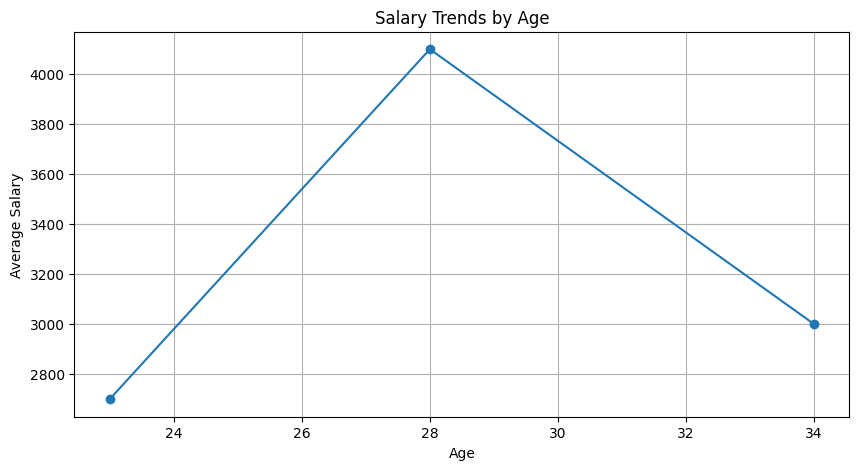

In [10]:
from pyspark.sql.functions import avg as _avg
import matplotlib.pyplot as plt
import pandas as pd

salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

Tugassssssss

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import round as _round, col, avg as _avg, sum as _sum, count as _count
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder \
    .appName("Homework_dataset") \
    .master("local[*]") \
    .getOrCreate()

departments_data = [
    (1, 'HR'),
    (2, 'Finance'),
    (3, 'Engineering'),
    (4, 'Marketing'),
    (5, 'Operator')
]
departments = spark.createDataFrame(departments_data, ['DeptId', 'DeptName'])
departments.createOrReplaceTempView("departments")

employees_data = [
    ('Anya_11', 37, 'F', 5100, 1),
    ('Ben_12', 30, 'M', 4500, 1),
    ('Cara_13', 25, 'F', 3800, 1),
    ('Dillon_14', 42, 'M', 5700, 1),
    ('Elena_15', 33, 'F', 4800, 1),
    ('Finn_16', 45, 'M', 6000, 1),
    ('Gia_17', 28, 'F', 4100, 1),
    ('Hugo_18', 39, 'M', 5400, 1),
    ('Iris_19', 31, 'F', 4600, 1),
    ('Jay_110', 44, 'M', 5900, 1),
    ('Kira_111', 26, 'F', 3900, 1),
    ('Liam_112', 38, 'M', 5200, 1),
    ('Mila_113', 35, 'F', 5000, 1),
    ('Noah_114', 40, 'M', 5500, 1),
    ('Opal_115', 32, 'F', 4700, 1),
    ('Paul_116', 43, 'M', 5800, 1),
    ('Quinn_117', 27, 'F', 4000, 1),
    ('Rico_118', 41, 'M', 5600, 1),
    ('Sara_119', 36, 'F', 5100, 1),
    ('Toby_120', 29, 'M', 4300, 1),

    ('Anya_21', 40, 'F', 5400, 2),
    ('Ben_22', 33, 'M', 4800, 2),
    ('Cara_23', 27, 'F', 4100, 2),
    ('Dillon_24', 45, 'M', 6100, 2),
    ('Elena_25', 36, 'F', 5000, 2),
    ('Finn_26', 29, 'M', 4400, 2),
    ('Gia_27', 31, 'F', 4600, 2),
    ('Hugo_28', 42, 'M', 5800, 2),
    ('Iris_29', 34, 'F', 4900, 2),
    ('Jay_210', 25, 'M', 3800, 2),
    ('Kira_211', 37, 'F', 5200, 2),
    ('Liam_212', 30, 'M', 4500, 2),
    ('Mila_213', 43, 'F', 5900, 2),
    ('Noah_214', 35, 'M', 5000, 2),
    ('Opal_215', 28, 'F', 4200, 2),
    ('Paul_216', 41, 'M', 5600, 2),
    ('Quinn_217', 32, 'F', 4700, 2),
    ('Rico_218', 38, 'M', 5300, 2),
    ('Sara_219', 26, 'F', 3900, 2),
    ('Toby_220', 39, 'M', 5500, 2),

    ('Anya_31', 35, 'F', 5000, 3),
    ('Ben_32', 28, 'M', 4200, 3),
    ('Cara_33', 40, 'F', 5500, 3),
    ('Dillon_34', 33, 'M', 4800, 3),
    ('Elena_35', 27, 'F', 4000, 3),
    ('Finn_36', 44, 'M', 6000, 3),
    ('Gia_37', 36, 'F', 5100, 3),
    ('Hugo_38', 29, 'M', 4300, 3),
    ('Iris_39', 41, 'F', 5600, 3),
    ('Jay_310', 34, 'M', 4900, 3),
    ('Kira_311', 25, 'F', 3800, 3),
    ('Liam_312', 39, 'M', 5400, 3),
    ('Mila_313', 31, 'F', 4600, 3),
    ('Noah_314', 42, 'M', 5800, 3),
    ('Opal_315', 38, 'F', 5300, 3),
    ('Paul_316', 32, 'M', 4700, 3),
    ('Quinn_317', 45, 'F', 6100, 3),
    ('Rico_318', 30, 'M', 4500, 3),
    ('Sara_319', 37, 'F', 5200, 3),
    ('Toby_320', 26, 'M', 3900, 3),

    ('Anya_41', 32, 'F', 4700, 4),
    ('Ben_42', 43, 'M', 5900, 4),
    ('Cara_43', 29, 'F', 4400, 4),
    ('Dillon_44', 36, 'M', 5000, 4),
    ('Elena_45', 40, 'F', 5500, 4),
    ('Finn_46', 33, 'M', 4800, 4),
    ('Gia_47', 25, 'F', 3800, 4),
    ('Hugo_48', 38, 'M', 5300, 4),
    ('Iris_49', 30, 'F', 4500, 4),
    ('Jay_410', 41, 'M', 5600, 4),
    ('Kira_411', 34, 'F', 4900, 4),
    ('Liam_412', 27, 'M', 4100, 4),
    ('Mila_413', 42, 'F', 5800, 4),
    ('Noah_414', 35, 'M', 5000, 4),
    ('Opal_415', 28, 'F', 4200, 4),
    ('Paul_416', 39, 'M', 5400, 4),
    ('Quinn_417', 37, 'F', 5200, 4),
    ('Rico_418', 31, 'M', 4600, 4),
    ('Sara_419', 45, 'F', 6100, 4),
    ('Toby_420', 26, 'M', 3900, 4),

    ('Anya_51', 29, 'F', 4400, 5),
    ('Ben_52', 40, 'M', 5500, 5),
    ('Cara_53', 33, 'F', 4800, 5),
    ('Dillon_54', 26, 'M', 3900, 5),
    ('Elena_55', 38, 'F', 5300, 5),
    ('Finn_56', 31, 'M', 4600, 5),
    ('Gia_57', 43, 'F', 5900, 5),
    ('Hugo_58', 36, 'M', 5100, 5),
    ('Iris_59', 27, 'F', 4000, 5),
    ('Jay_510', 45, 'M', 6100, 5),
    ('Kira_511', 39, 'F', 5400, 5),
    ('Liam_512', 32, 'M', 4700, 5),
    ('Mila_513', 25, 'F', 3800, 5),
    ('Noah_514', 42, 'M', 5800, 5),
    ('Opal_515', 35, 'F', 5000, 5),
    ('Paul_516', 28, 'M', 4200, 5),
    ('Quinn_517', 41, 'F', 5600, 5),
    ('Rico_518', 34, 'M', 4900, 5),
    ('Sara_519', 30, 'F', 4500, 5),
    ('Toby_520', 37, 'M', 5200, 5)
]

employees = spark.createDataFrame(employees_data, ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
employees.createOrReplaceTempView("employees")

25/12/14 19:14:12 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Tugas 1: Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen.
         Buat visualisasi perbandingan antar departemen.


Tugas 1: Total gaji & jumlah karyawan per departemen
+-----------+--------------+---------+------------+
|   DeptName|JumlahKaryawan|TotalGaji|RataRataGaji|
+-----------+--------------+---------+------------+
|         HR|            20|    99000|      4950.0|
|Engineering|            20|    98700|      4935.0|
|   Operator|            20|    98700|      4935.0|
|    Finance|            20|    98700|      4935.0|
|  Marketing|            20|    98700|      4935.0|
+-----------+--------------+---------+------------+



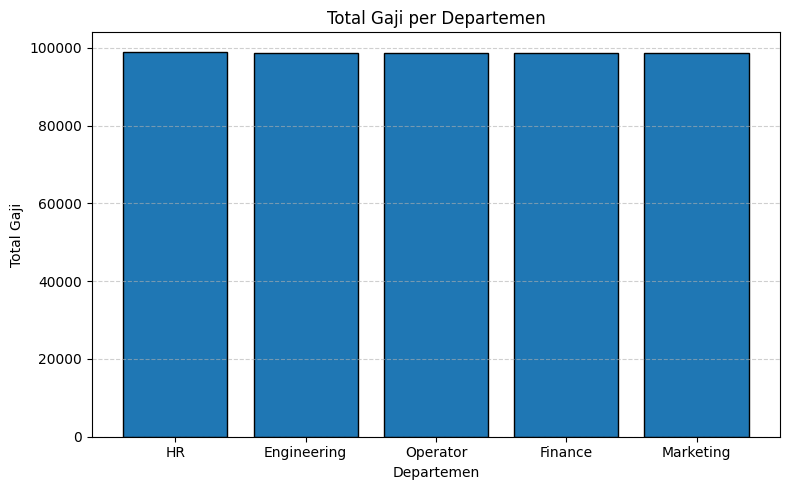

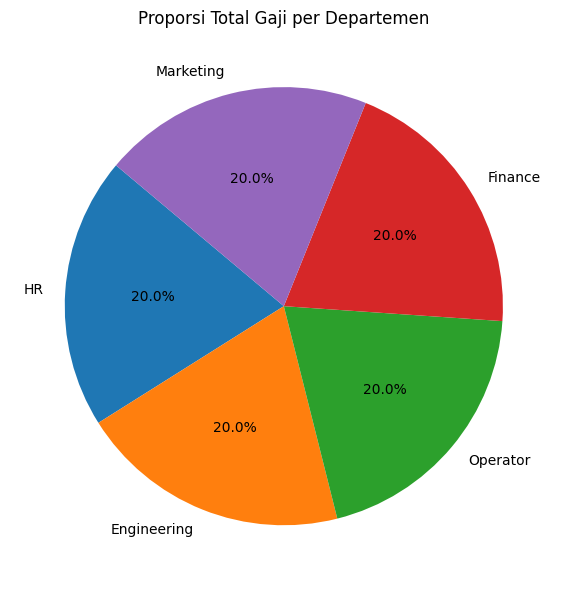

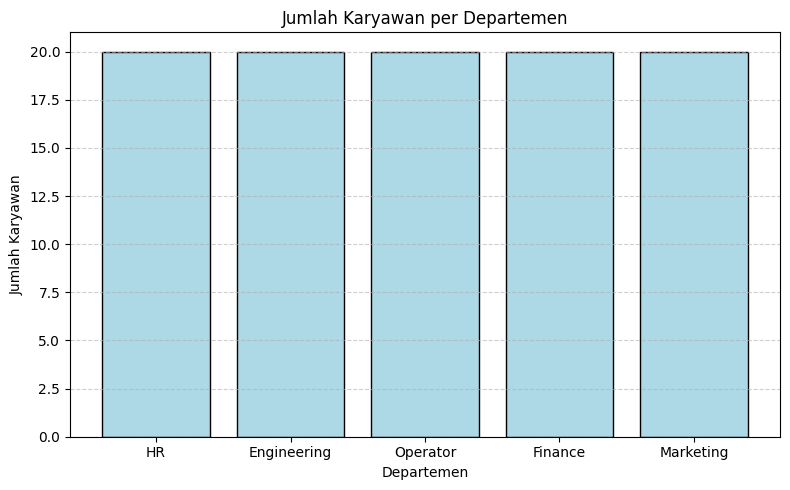

In [13]:
t1 = spark.sql("""
SELECT d.DeptName,
       COUNT(*) AS JumlahKaryawan,
       ROUND(SUM(e.Salary),2) AS TotalGaji,
       ROUND(AVG(e.Salary),2) AS RataRataGaji
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY TotalGaji DESC
""")
t1.createOrReplaceTempView("t1_dept_salary_count")
print("\nTugas 1: Total gaji & jumlah karyawan per departemen")
t1.show()

# bar chart
pdf_t1 = t1.toPandas()
plt.figure(figsize=(8,5))
plt.bar(pdf_t1['DeptName'], pdf_t1['TotalGaji'], edgecolor='black')
plt.title('Total Gaji per Departemen')
plt.xlabel('Departemen')
plt.ylabel('Total Gaji')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# pie chart
plt.figure(figsize=(6,6))
plt.pie(pdf_t1['TotalGaji'], labels=pdf_t1['DeptName'], autopct='%1.1f%%', startangle=140)
plt.title('Proporsi Total Gaji per Departemen')
plt.tight_layout()
plt.show()

# bar chart
plt.figure(figsize=(8,5))
plt.bar(pdf_t1['DeptName'], pdf_t1['JumlahKaryawan'], edgecolor='black', color='lightblue')
plt.title('Jumlah Karyawan per Departemen')
plt.xlabel('Departemen')
plt.ylabel('Jumlah Karyawan')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Tugas 2: Temukan karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia 
         dan visualisasikan data ini dalam bentuk grafik batang atau pie chart.


Rata-rata gaji per kelompok usia
+--------+---------+
|AgeGroup|AvgSalary|
+--------+---------+
|     20s|   4056.0|
|     30s|   4944.9|
|     40s|  5773.08|
+--------+---------+


Karyawan dengan gaji di atas rata-rata per kelompok usia (sample 50)
+--------+---+--------+------+------+-----------+
|    Name|Age|AgeGroup|Gender|Salary|   DeptName|
+--------+---+--------+------+------+-----------+
| Finn_26| 29|     20s|     M|  4400|    Finance|
| Cara_43| 29|     20s|     F|  4400|  Marketing|
| Anya_51| 29|     20s|     F|  4400|   Operator|
|Toby_120| 29|     20s|     M|  4300|         HR|
| Hugo_38| 29|     20s|     M|  4300|Engineering|
|Opal_215| 28|     20s|     F|  4200|    Finance|
|  Ben_32| 28|     20s|     M|  4200|Engineering|
|Opal_415| 28|     20s|     F|  4200|  Marketing|
|Paul_516| 28|     20s|     M|  4200|   Operator|
|  Gia_17| 28|     20s|     F|  4100|         HR|
| Cara_23| 27|     20s|     F|  4100|    Finance|
|Liam_412| 27|     20s|     M|  4100|  Marketing

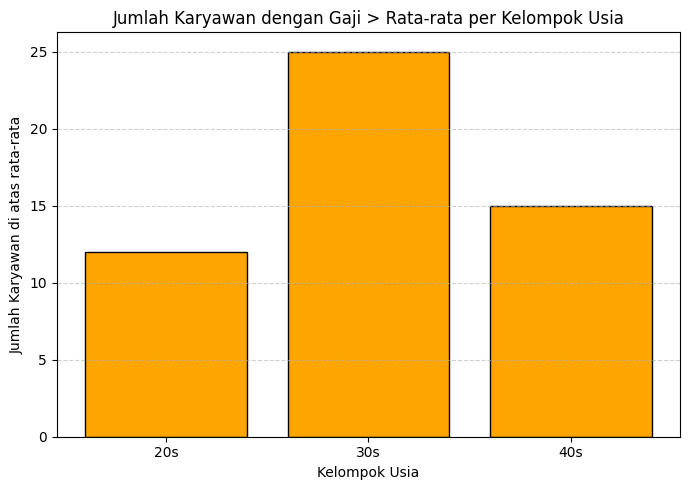

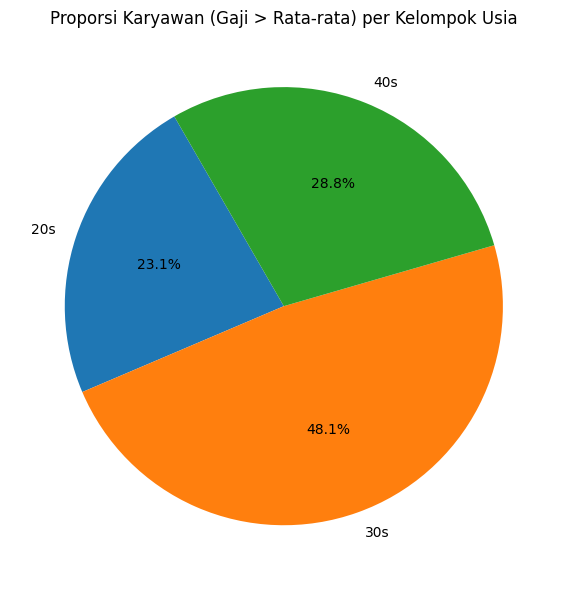

In [14]:
employees_with_agegroup = employees.withColumn("AgeGroup",
    when((col("Age") >= 20) & (col("Age") < 30), "20s")
    .when((col("Age") >= 30) & (col("Age") < 40), "30s")
    .when((col("Age") >= 40) & (col("Age") < 50), "40s")
    .otherwise("50s+")
)
employees_with_agegroup.createOrReplaceTempView("employees_ag")

spark.sql("""
SELECT AgeGroup, ROUND(AVG(Salary),2) AS AvgSalary
FROM employees_ag
GROUP BY AgeGroup
ORDER BY AgeGroup
""").createOrReplaceTempView("avg_by_agegroup")

print("\nRata-rata gaji per kelompok usia")
spark.sql("SELECT * FROM avg_by_agegroup").show()

spark.sql("""
SELECT e.Name, e.Age, e.AgeGroup, e.Gender, e.Salary, d.DeptName
FROM employees_ag e
JOIN avg_by_agegroup a ON e.AgeGroup = a.AgeGroup
JOIN departments d ON e.DeptId = d.DeptId
WHERE e.Salary > a.AvgSalary
ORDER BY e.AgeGroup, e.Salary DESC
""").createOrReplaceTempView("above_avg_by_agegroup")

print("\nKaryawan dengan gaji di atas rata-rata per kelompok usia (sample 50)")
spark.sql("SELECT * FROM above_avg_by_agegroup LIMIT 50").show()

summary_above = spark.sql("""
SELECT AgeGroup, COUNT(*) AS CountAboveAvg, ROUND(AVG(Salary),2) AS AvgSalaryAbove
FROM above_avg_by_agegroup
GROUP BY AgeGroup
ORDER BY AgeGroup
""")
summary_above.show()
pdf_above = summary_above.toPandas()
# bar chart
plt.figure(figsize=(7,5))
plt.bar(pdf_above['AgeGroup'], pdf_above['CountAboveAvg'], edgecolor='black', color='orange')
plt.title('Jumlah Karyawan dengan Gaji > Rata-rata per Kelompok Usia')
plt.xlabel('Kelompok Usia')
plt.ylabel('Jumlah Karyawan di atas rata-rata')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# pie chart
plt.figure(figsize=(6,6))
plt.pie(pdf_above['CountAboveAvg'], labels=pdf_above['AgeGroup'], autopct='%1.1f%%', startangle=120)
plt.title('Proporsi Karyawan (Gaji > Rata-rata) per Kelompok Usia')
plt.tight_layout()
plt.show()

Tugas 3: Buat dataset yang lebih besar (misalnya, 100+ baris) dan lakukan analisis mendalam 
         menggunakan SQL functions seperti SUM(), AVG(), COUNT(), serta JOIN antar tabel serta buat visualisasi yang menarik.


Tugas 3: Analisis mendalam menggunakan (SUM(), AVG(), COUNT(), JOIN)
+-----------+--------------+---------+------------+-------+-------+
|   DeptName|JumlahKaryawan|TotalGaji|RataRataGaji|GajiMin|GajiMax|
+-----------+--------------+---------+------------+-------+-------+
|         HR|            20|    99000|      4950.0|   3800|   6000|
|Engineering|            20|    98700|      4935.0|   3800|   6100|
|   Operator|            20|    98700|      4935.0|   3800|   6100|
|    Finance|            20|    98700|      4935.0|   3800|   6100|
|  Marketing|            20|    98700|      4935.0|   3800|   6100|
+-----------+--------------+---------+------------+-------+-------+



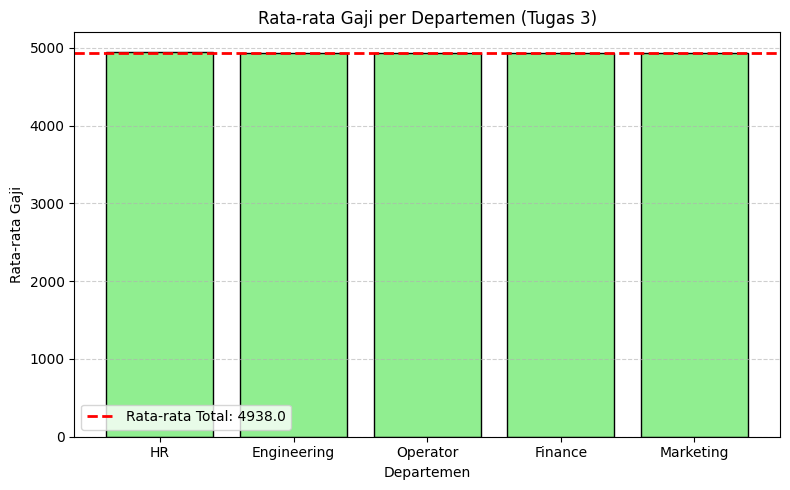

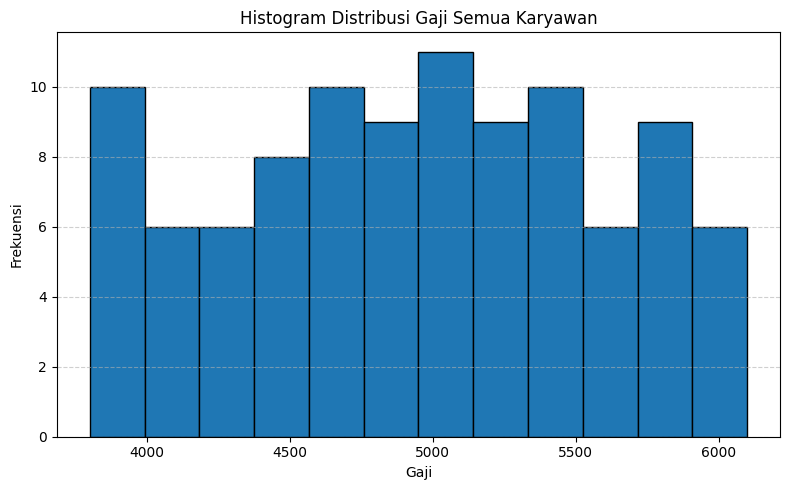

/tmp/ipykernel_4188/1818856620.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=pdf_all['DeptName'].unique(), patch_artist=True)


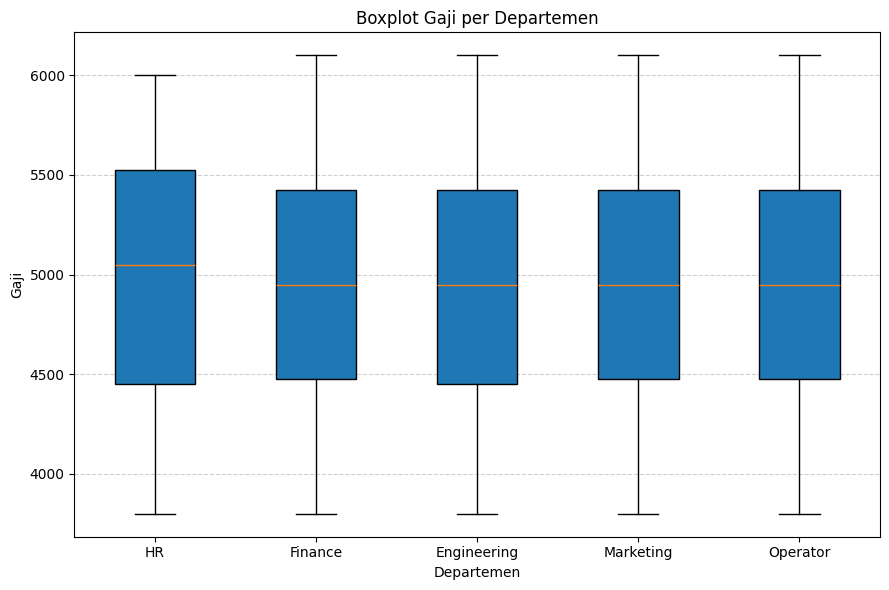


Top 10 Karyawan bergaji tertinggi
+---------+---+------+------+-----------+
|Name     |Age|Gender|Salary|DeptName   |
+---------+---+------+------+-----------+
|Dillon_24|45 |M     |6100  |Finance    |
|Quinn_317|45 |F     |6100  |Engineering|
|Sara_419 |45 |F     |6100  |Marketing  |
|Jay_510  |45 |M     |6100  |Operator   |
|Finn_16  |45 |M     |6000  |HR         |
|Finn_36  |44 |M     |6000  |Engineering|
|Jay_110  |44 |M     |5900  |HR         |
|Mila_213 |43 |F     |5900  |Finance    |
|Ben_42   |43 |M     |5900  |Marketing  |
|Gia_57   |43 |F     |5900  |Operator   |
+---------+---+------+------+-----------+



In [15]:
deep_stats = spark.sql("""
SELECT d.DeptName,
       COUNT(e.Name) AS JumlahKaryawan,
       ROUND(SUM(e.Salary),2) AS TotalGaji,
       ROUND(AVG(e.Salary),2) AS RataRataGaji,
       ROUND(MIN(e.Salary),2) AS GajiMin,
       ROUND(MAX(e.Salary),2) AS GajiMax
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY RataRataGaji DESC
""")
print("\nTugas 3: Analisis mendalam menggunakan (SUM(), AVG(), COUNT(), JOIN)")
deep_stats.show()

pdf_deep = deep_stats.toPandas()
avg_total_all = employees.select(_round(_avg(col("Salary")),2).alias("avg_all")).collect()[0]['avg_all']

# Bar Chart
plt.figure(figsize=(8,5))
plt.bar(pdf_deep['DeptName'], pdf_deep['RataRataGaji'], edgecolor='black', color='lightgreen')
plt.axhline(y=avg_total_all, color='red', linestyle='--', linewidth=2, label=f'Rata-rata Total: {avg_total_all}')
plt.title('Rata-rata Gaji per Departemen (Tugas 3)')
plt.xlabel('Departemen')
plt.ylabel('Rata-rata Gaji')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Histogram 
pdf_salary = employees.select("Salary").toPandas()
plt.figure(figsize=(8,5))
plt.hist(pdf_salary['Salary'], bins=12, edgecolor='black')
plt.title('Histogram Distribusi Gaji Semua Karyawan')
plt.xlabel('Gaji')
plt.ylabel('Frekuensi')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Boxplot 
pdf_all = employees.join(departments, "DeptId").select("DeptName", "Salary").toPandas()
groups = [pdf_all[pdf_all['DeptName'] == d]['Salary'].values for d in pdf_all['DeptName'].unique()]

plt.figure(figsize=(9,6))
plt.boxplot(groups, labels=pdf_all['DeptName'].unique(), patch_artist=True)
plt.title('Boxplot Gaji per Departemen')
plt.xlabel('Departemen')
plt.ylabel('Gaji')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nTop 10 Karyawan bergaji tertinggi")
spark.sql("""
SELECT e.Name, e.Age, e.Gender, e.Salary, d.DeptName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY e.Salary DESC
LIMIT 10
""").show(truncate=False)

/tmp/ipykernel_4188/184753657.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=pdf_all['DeptName'].unique(), patch_artist=True)


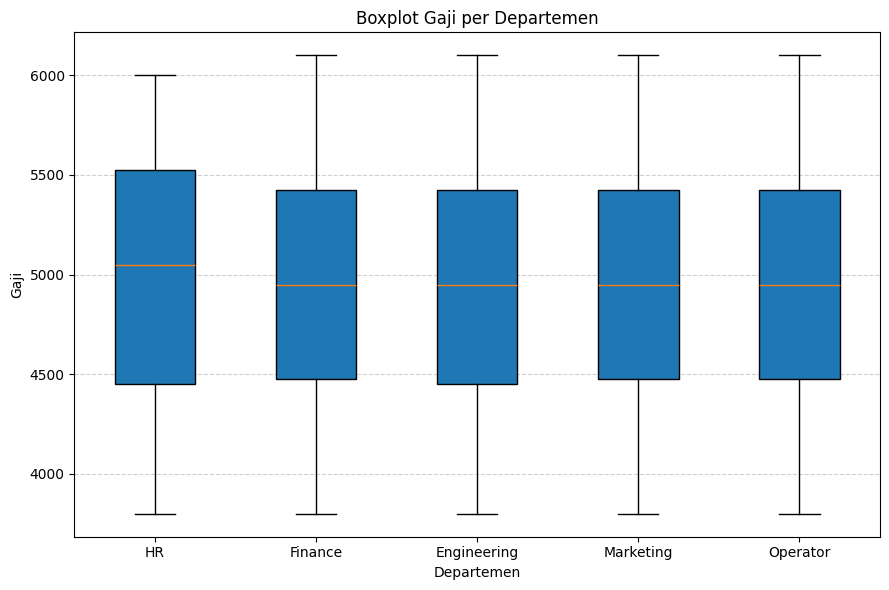

In [19]:
# Boxplot 
pdf_all = employees.join(departments, "DeptId").select("DeptName", "Salary").toPandas()
groups = [pdf_all[pdf_all['DeptName'] == d]['Salary'].values for d in pdf_all['DeptName'].unique()]

plt.figure(figsize=(9,6))
plt.boxplot(groups, labels=pdf_all['DeptName'].unique(), patch_artist=True)
plt.title('Boxplot Gaji per Departemen')
plt.xlabel('Departemen')
plt.ylabel('Gaji')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

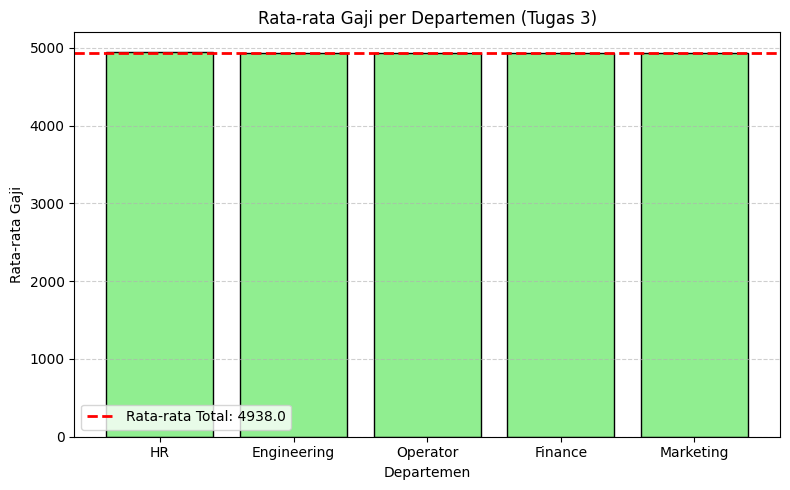

In [16]:
# Bar Chart
plt.figure(figsize=(8,5))
plt.bar(pdf_deep['DeptName'], pdf_deep['RataRataGaji'], edgecolor='black', color='lightgreen')
plt.axhline(y=avg_total_all, color='red', linestyle='--', linewidth=2, label=f'Rata-rata Total: {avg_total_all}')
plt.title('Rata-rata Gaji per Departemen (Tugas 3)')
plt.xlabel('Departemen')
plt.ylabel('Rata-rata Gaji')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()